# Sandbox
For playing around during development.

In [30]:
%pylab inline
import pysd
#print pysd.__version__
print pysd.__file__
import pandas as pd
import os
import xarray as xr

Populating the interactive namespace from numpy and matplotlib
pysd/__init__.pyc


In [54]:
ret = xr.DataArray(
        data=np.ones([3, 2, 2]) * np.NaN,
        coords={'Second Dimension Subscript': ['Column 1', 'Column 2'],
                'One Dimensional Subscript': ['Entry 1', 'Entry 2', 'Entry 3'],
                'Third Dimension Subscript': ['Depth 1', 'Depth 2']}, 
        dims=['One Dimensional Subscript', 'Second Dimension Subscript', 'Third Dimension Subscript'])
ret.loc[{'Third Dimension Subscript': ['Depth 1']}] = [[[1, 2], [3, 4], [5, 6]]]
#ret.loc[{'Third Dimension Subscript': ['Depth 2']}] = [2, 4], [5, 3], [1, 4]

ValueError: shape mismatch: value array of shape (1,3,2) could not be broadcast to indexing result of shape (1,3,2)

In [53]:
ret.loc[{'Third Dimension Subscript': ['Depth 1']}] = 

<xarray.DataArray (One Dimensional Subscript: 3, Second Dimension Subscript: 2, Third Dimension Subscript: 1)>
array([[[ nan],
        [ nan]],

       [[ nan],
        [ nan]],

       [[ nan],
        [ nan]]])
Coordinates:
  * Second Dimension Subscript  (Second Dimension Subscript) |S8 'Column 1' ...
  * One Dimensional Subscript   (One Dimensional Subscript) |S7 'Entry 1' ...
  * Third Dimension Subscript   (Third Dimension Subscript) |S7 'Depth 1'

In [47]:
ret = xr.DataArray(
        data=np.ones([3, 2, 2]) * np.NaN,
        coords={'Second Dimension Subscript': ['Column 1', 'Column 2'],
                'One Dimensional Subscript': ['Entry 1', 'Entry 2', 'Entry 3'],
                'Third Dimension Subscript': ['Depth 1', 'Depth 2']}, 
        dims=['One Dimensional Subscript', 'Second Dimension Subscript', 'Third Dimension Subscript'])
ret.loc[{'Third Dimension Subscript': ['Depth 1']}] = \
    xr.DataArray(data=[[1, 2], [3, 4], [5, 6]],
                 coords={'Second Dimension Subscript': ['Column 1', 'Column 2'],
                         'One Dimensional Subscript': ['Entry 1', 'Entry 2', 'Entry 3']},
                 dims=['One Dimensional Subscript', 'Second Dimension Subscript'])

ValueError: shape mismatch: value array of shape (3,2) could not be broadcast to indexing result of shape (1,3,2)

In [14]:
import scipy.stats as stats

In [22]:
stats.norm.cdf(np.arange(-10,0.1,.1))

array([  7.61985302e-24,   2.08137522e-23,   5.62928231e-23,
         1.50749317e-22,   3.99722121e-22,   1.04945151e-21,
         2.72815357e-21,   7.02228424e-21,   1.78974881e-20,
         4.51659149e-20,   1.12858841e-19,   2.79233437e-19,
         6.84080769e-19,   1.65942087e-18,   3.98580496e-18,
         9.47953482e-18,   2.23239320e-17,   5.20556974e-17,
         1.20193515e-16,   2.74795939e-16,   6.22096057e-16,
         1.39451715e-15,   3.09535877e-15,   6.80331154e-15,
         1.48065375e-14,   3.19089167e-14,   6.80922489e-14,
         1.43883864e-13,   3.01062798e-13,   6.23784446e-13,
         1.27981254e-12,   2.60012697e-12,   5.23095754e-12,
         1.04209770e-11,   2.05578891e-11,   4.01600058e-11,
         7.76884758e-11,   1.48822822e-10,   2.82315804e-10,
         5.30342326e-10,   9.86587645e-10,   1.81750786e-09,
         3.31574598e-09,   5.99037140e-09,   1.07175903e-08,
         1.89895625e-08,   3.33204485e-08,   5.79013404e-08,
         9.96442632e-08,

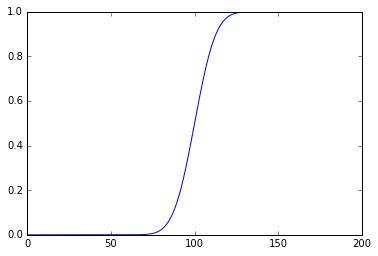

In [19]:
plt.plot(stats.norm.cdf(np.arange(-10,10,.1)))

In [3]:
model = pysd.read_vensim('./tests/test-models/tests/abs/test_abs.mdl')
model

ValueError: shape mismatch: value array of shape (3,2) could not be broadcast to indexing result of shape (1,2,3)

In [3]:
xr.DataArray(data=[[0.01,0.02],[0.03,0.04],[0.05,0.06]], coords={'Dim2': ['D', 'E'], 
                                                                 'Dim1': ['A', 'B', 'C']}, dims=['Dim1', 'Dim2'] )

<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[ 0.01,  0.02],
       [ 0.03,  0.04],
       [ 0.05,  0.06]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [5]:
xr.DataArray(data=10, coords={'Dim2': ['D', 'E'], 'Dim1': ['A', 'B', 'C']}, dims=['Dim1', 'Dim2'] )

KeyError: 'Dim2'

In [8]:
a = xr.DataArray(data=np.ones([3])*10, coords={'Dim1': ['A', 'B', 'C']})

In [9]:
xr.DataArray(data=np.ones([2, 3])*10, coords={'Dim2': ['D', 'E'], 'Dim1': ['A', 'B', 'C']})

<xarray.DataArray (Dim2: 2, Dim1: 3)>
array([[ 10.,  10.,  10.],
       [ 10.,  10.,  10.]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [2]:
import xarray as xr

In [4]:
coords = {'Second Dimension Subscript': ['Column 1', 'Column 2'],
          'Third Dimension Subscript': ['Depth 1', 'Depth 2'],
          'One Dimensional Subscript': ['Entry 1', 'Entry 2', 'Entry 3']}
coords

{'One Dimensional Subscript': ['Entry 1', 'Entry 2', 'Entry 3'],
 'Second Dimension Subscript': ['Column 1', 'Column 2'],
 'Third Dimension Subscript': ['Depth 1', 'Depth 2']}

## working out how to assign values to xarray values

In [118]:
# create an xarray dataarray filled with NaN
coords={'Dim2': ['D', 'E'], 'Dim1': ['A', 'B', 'C']}
dims = ['Dim1', 'Dim2']
a = xr.DataArray(data=[[.1, .2],[.3,.4],[.5,.6]], coords=coords, dims=['Dim1', 'Dim2'])
a.loc[coords]

<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[ 0.1,  0.2],
       [ 0.3,  0.4],
       [ 0.5,  0.6]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [123]:
# create an xarray dataarray filled with NaN
coords={'Dim2': ['D', 'E'], 'Dim1': ['A', 'B', 'C']}
dims = ['Dim1', 'Dim2']
shape = [len(coords[key]) for key in dims]
a = xr.DataArray(data=np.zeros(shape)*NaN, coords=coords, dims=dims)
a.loc[coords]

<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [112]:
# assign all values to a scalar
a.loc[coords] = 3
a.loc[coords]

<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[ 3.,  3.],
       [ 3.,  3.],
       [ 3.,  3.]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [113]:
# fill all values
a.loc[coords] = [1,2],[3,4],[5,6]
a.loc[coords]

<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[ 1.,  2.],
       [ 3.,  4.],
       [ 5.,  6.]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [114]:
# modify values directly without index slicing
values = [10,20],[30,40],[50,60]
a.values = np.array(values)
a.loc[coords]

<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[10, 20],
       [30, 40],
       [50, 60]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [120]:
# select a slice
a.loc[{'Dim2':['D']}] 

<xarray.DataArray (Dim1: 3, Dim2: 1)>
array([[ nan],
       [ nan],
       [ nan]])
Coordinates:
  * Dim2     (Dim2) |S1 'D'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [122]:
# assign to a slice (the orientation matters!)
a.loc[{'Dim2':['D']}] = 1, 2, 3
a.loc[coords]

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (1,3)

In [117]:
#assign to a slice with properly aligned array
a.loc[{'Dim2':['D']}] = [1], [2], [3]
a.loc[coords]


<xarray.DataArray (Dim1: 3, Dim2: 2)>
array([[ 1, 20],
       [ 2, 40],
       [ 3, 60]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [125]:
# add a new slice
new_coords={'Dim1': ['A', 'B', 'C']}
new_slice = xr.DataArray(data=[1.1, 2.2, 3.3], coords=new_coords)
new_slice

<xarray.DataArray (Dim1: 3)>
array([ 1.1,  2.2,  3.3])
Coordinates:
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [127]:
# update df with a new slice
a.update(new_slice)
a

AttributeError: 'DataArray' object has no attribute 'update'

In [130]:
m = xr.DataArray(data=[1.1, 1.2, 1.3], 
                 coords={'Dim1': ['A', 'B', 'C'], 'Dim2':['D']})
n = xr.DataArray(data=[2.1, 2.2, 2.3], 
                 coords={'Dim1': ['A', 'B', 'C'], 'Dim2':['E']})

ValueError: coordinate Dim2 has dimensions ('Dim2',), but these are not a subset of the DataArray dimensions ('dim_0',)

In [133]:
m = xr.DataArray(data=[[1.1, 1.2, 1.3]], 
                 coords={'Dim1': ['A', 'B', 'C'], 'Dim2':['D']})
n = xr.DataArray(data=[[2.1, 2.2, 2.3]], 
                 coords={'Dim1': ['A', 'B', 'C'], 'Dim2':['E']})

a = xr.concat([m, n], dim='Dim2')
a

<xarray.DataArray (Dim2: 2, Dim1: 3)>
array([[ 1.1,  1.2,  1.3],
       [ 2.1,  2.2,  2.3]])
Coordinates:
  * Dim1     (Dim1) |S1 'A' 'B' 'C'
  * Dim2     (Dim2) |S1 'D' 'E'

In [80]:
a.loc[coords] = [1,2],[3,4],[5,6]

In [75]:
values = [1,2],[3,4],[5,6]
a.values = np.array(values)

In [98]:
coords={'Dim1': ['A', 'B', 'C'], 'Dim2': ['D', 'E']}
a = xr.DataArray(data=[[1,2],[3,4],[5,6]], coords=coords, dims=['Dim1', 'Dim2'])


In [43]:
a = xr.DataArray(data=np.zeros(map(len, coords.values()))*NaN, coords=coords)

In [72]:
m = np.empty([3])*NaN
m

array([ nan,  nan,  nan])

In [70]:
np.empty(4)

array([ 1.,  2.,  3.,  4.])

In [49]:
a.sel(One Dimensional Subscript='Column 1')

SyntaxError: invalid syntax (<ipython-input-49-f3f8947e1e9d>, line 1)

In [36]:
a.loc[{'One Dimensional Subscript': ['Entry 1']}]

<xarray.DataArray (Second Dimension Subscript: 2, Third Dimension Subscript: 2, One Dimensional Subscript: 1)>
array([[[ 1.],
        [ 2.]],

       [[ 3.],
        [ 4.]]])
Coordinates:
  * Second Dimension Subscript  (Second Dimension Subscript) |S8 'Column 1' ...
  * Third Dimension Subscript   (Third Dimension Subscript) |S7 'Depth 1' ...
  * One Dimensional Subscript   (One Dimensional Subscript) |S7 'Entry 1'

In [ ]:
a.loc[{'One Dimensional Subscript': ['Entry 1']}]

In [18]:
a.loc[:,:,'Entry 1']

<xarray.DataArray (Second Dimension Subscript: 2, Third Dimension Subscript: 2)>
array([[ 1.,  2.],
       [ 0.,  0.]])
Coordinates:
  * Second Dimension Subscript  (Second Dimension Subscript) |S8 'Column 1' ...
  * Third Dimension Subscript   (Third Dimension Subscript) |S7 'Depth 1' ...
    One Dimensional Subscript   |S7 'Entry 1'

In [37]:
a.loc[:,'Entry 1',:]

KeyError: 'Entry 1'

In [16]:
a.loc['Column 1',:,'Entry 1']

<xarray.DataArray (Third Dimension Subscript: 2)>
array([ 0.,  0.])
Coordinates:
    Second Dimension Subscript  |S8 'Column 1'
  * Third Dimension Subscript   (Third Dimension Subscript) |S7 'Depth 1' ...
    One Dimensional Subscript   |S7 'Entry 1'

In [17]:
a.loc['Column 1',:,'Entry 1'] = 1, 2

In [21]:
a.loc[:,:,'Entry 1'] = [1,2],[3,4]

In [22]:
a

<xarray.DataArray (Second Dimension Subscript: 2, Third Dimension Subscript: 2, One Dimensional Subscript: 3)>
array([[[ 1.,  0.,  0.],
        [ 2.,  0.,  0.]],

       [[ 3.,  0.,  0.],
        [ 4.,  0.,  0.]]])
Coordinates:
  * Second Dimension Subscript  (Second Dimension Subscript) |S8 'Column 1' ...
  * Third Dimension Subscript   (Third Dimension Subscript) |S7 'Depth 1' ...
  * One Dimensional Subscript   (One Dimensional Subscript) |S7 'Entry 1' ...

In [25]:
a.loc[:,:,'Entry 1'] = [1,2],[3,4]

In [26]:
a

<xarray.DataArray (Second Dimension Subscript: 2, Third Dimension Subscript: 2, One Dimensional Subscript: 3)>
array([[[ 1.,  0.,  0.],
        [ 2.,  0.,  0.]],

       [[ 3.,  0.,  0.],
        [ 4.,  0.,  0.]]])
Coordinates:
  * Second Dimension Subscript  (Second Dimension Subscript) |S8 'Column 1' ...
  * Third Dimension Subscript   (Third Dimension Subscript) |S7 'Depth 1' ...
  * One Dimensional Subscript   (One Dimensional Subscript) |S7 'Entry 1' ...

In [50]:
m = {'Dim1': ['A', 'B'],
                                      'Dim2': ['C', 'D', 'E'],
                                      'Dim3': ['F', 'G', 'H', 'I']}

In [53]:
m.iterkeys()

<dictionary-keyiterator at 0x10d7459f0>

In [37]:
frame = {'elem1': 'hibob'}

In [48]:
frame = {'elem1': xr.DataArray([[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                                       {'Dim1': ['A', 'B', 'C'],
                                        'Dim2': ['D', 'E', 'F']}),
         'elem2': xr.DataArray([[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                                       {'Dim1': ['A', 'B', 'C'],
                                        'Dim2': ['D', 'E', 'F']})}

return_addresses = {'Elem1': ('elem1', {'Dim1': ['B'], 'Dim2': ['F']})}

In [109]:
pyname = 'elem1',
for real_name, (pyname, address) in return_addresses.iteritems():
    a = frame[pyname].loc[address]

In [120]:
max(a.shape)

1

In [125]:
a.values.shape

(1, 1)

In [110]:
a == 8

<xarray.DataArray (Dim2: 1, Dim1: 1)>
array([[ True]], dtype=bool)
Coordinates:
  * Dim2     (Dim2) |S1 'F'
  * Dim1     (Dim1) |S1 'B'

In [111]:
b = a.values.squeeze()

In [117]:
val = b.squeeze()
val.flatten()

array([8])

In [100]:
b = np.squeeze(a.values)

In [108]:
float(a)

TypeError: only length-1 arrays can be converted to Python scalars

In [42]:
xr.DataArray([[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                                       {'Dim1': ['A', 'B', 'C'],
                                        'Dim2': ['D', 'E', 'F']})

<xarray.DataArray (Dim2: 3, Dim1: 3)>
array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])
Coordinates:
  * Dim2     (Dim2) |S1 'D' 'E' 'F'
  * Dim1     (Dim1) |S1 'A' 'B' 'C'

In [12]:
a = {'Hi': 3}
b = a
a['Hi'] = 4
b

{'Hi': 4}

In [13]:
a.values

<function values>

In [ ]:
a.iter